In [1]:
# from google.colab import drive
# mount_path = '/content/gdrive/'
# drive.mount(mount_path)

In [2]:
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import os
%matplotlib inline
from os import listdir
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [3]:
# data_path = 'My Drive/project2'
# data_dir = mount_path + data_path
# print(data_dir)

In [4]:
X = pd.read_pickle('X1.pkl')
y = pd.read_pickle('y1.pkl')
for i in range(1,13):
    tmp_X = pd.read_pickle(f'X{i+1}.pkl')
    tmp_y = pd.read_pickle(f'y{i+1}.pkl')
    X = np.concatenate((X, tmp_X), axis=0)
    y = y.append(tmp_y, ignore_index=True)

In [5]:
X.shape

(12973,)

In [6]:
X = np.stack(X, axis=0)
print('X shape', X.shape, '\ny shape', y.shape)

X shape (12973, 224, 224, 3) 
y shape (12973, 10)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=42)


In [8]:
X_train.shape

(10378, 224, 224, 3)

In [9]:
xception_model = Xception(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

In [10]:
model = Sequential(
    [xception_model,
     Flatten(),
     Dense(128, activation='relu'),
     Dense(10, activation='sigmoid')]
)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               12845184  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 33,707,954
Trainable params: 33,653,426
Non-trainable params: 54,528
_________________________________________________________________


In [12]:
xception_model.trainable = False

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               12845184  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 33,707,954
Trainable params: 12,846,474
Non-trainable params: 20,861,480
_________________________________________________________________


In [14]:

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_checkpoint_callback = ModelCheckpoint(
                            filepath = './',
                            save_weights_only = False,
                            monitor = 'val_accuracy',
                            mode = 'max',
                            save_best_only = True)
earlystop = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

In [15]:
# datagen = ImageDataGenerator( 
#                             rotation_range = 90,
#                             horizontal_flip=True,
#                             vertical_flip = True
#                             )

# train_gen = datagen.flow(X_train, y_train)

In [16]:
history = model.fit(X_train, y_train,
                    epochs = 15,
                    batch_size = 64,
                    validation_split = 0.1,
                    callbacks=[model_checkpoint_callback, earlystop])

Train on 9340 samples, validate on 1038 samples
Epoch 1/15
9280/9340 [============================>.] - ETA: 24s - loss: 0.4100 - accuracy: 0.8878WARNING:tensorflow:From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./assets
9340/9340 [==============================] - 3984s 427ms/sample - loss: 0.4089 - accuracy: 0.8880 - val_loss: 12.0227 - val_accuracy: 0.7284
Epoch 2/15
9340/9340 [==============================] - 3990s 427ms/sample - loss: 0.1857 - accuracy: 0.9287 - val_loss: 19.6603 - val_accuracy: 0.7405
Epoch 3/15
9340/9340 [==============================] - 3982s 426ms/sample - loss: 0.1449 - accuracy: 0.9438 - val_loss: 27.6574 - val_accuracy: 0.7418

In [17]:
def plot_loss_over_epoches(history):

    fig, ax = plt.subplots(1, 1, figsize=(7, 4))
    ax.plot(history.history['accuracy'], color='salmon', label="Training accuracy")
    ax.plot(history.history['val_accuracy'], color='purple', label="validation accuracy")
    ax.set_title("Accuracy over epoches")
    ax.grid(alpha=0.2)
    legend = ax.legend(loc='best', shadow=True)

    plt.tight_layout()
    plt.show()
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 4))
    ax.plot(history.history['loss'], color='salmon', label="Training loss")
    ax.plot(history.history['val_loss'], color='purple', label="validation loss")
    ax.set_title("Loss over epoches")
    ax.grid(alpha=0.2)
    legend = ax.legend(loc='best', shadow=True)

    plt.tight_layout()
    plt.show()

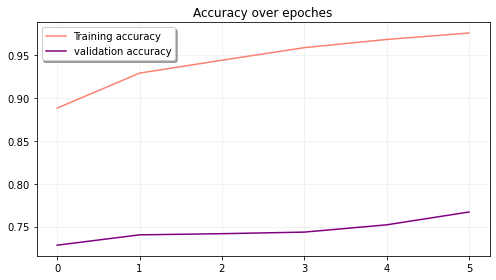

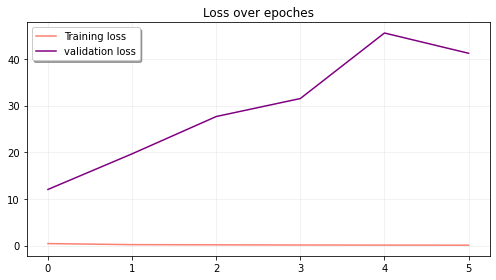

In [18]:
plot_loss_over_epoches(history)

In [19]:
y_pred = model.predict(X_test)

In [20]:
col_dict = dict(zip(np.arange(10), y.columns))
col_dict

{0: 'keyword_animal',
 1: 'keyword_human',
 2: 'keyword_mountain',
 3: 'keyword_nature',
 4: 'keyword_outdoors',
 5: 'keyword_person',
 6: 'keyword_plant',
 7: 'keyword_sea',
 8: 'keyword_tree',
 9: 'keyword_water'}

In [21]:
def pic(X, y_pred, col_dict): 
    print('-------------------------------------------')
    for i in range(10):
      confidence = (round(y_pred[i], 4) * 100)
      if confidence > 20:
        print(f'{col_dict[i]} - {confidence}%')
    plt.figure(figsize=(6,6))
    plt.imshow(X)
    plt.axis('off')
    plt.show()
    print('-------------------------------------------', end='\n\n\n')

-------------------------------------------
keyword_human - 56.279999017715454%
keyword_nature - 100.0%


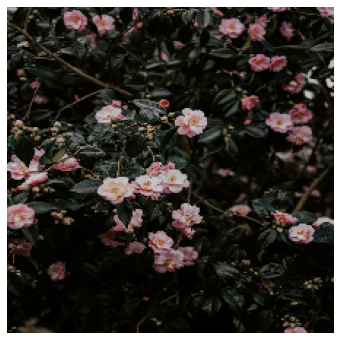

-------------------------------------------


-------------------------------------------
keyword_nature - 100.0%


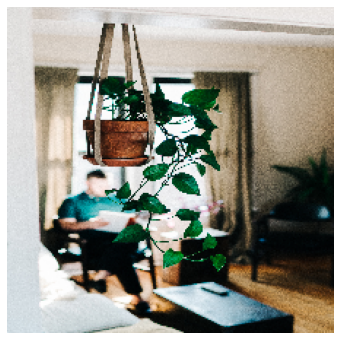

-------------------------------------------


-------------------------------------------
keyword_nature - 100.0%


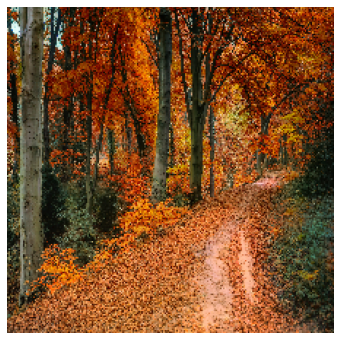

-------------------------------------------


-------------------------------------------
keyword_human - 28.790000081062317%
keyword_nature - 99.37999844551086%
keyword_person - 95.93999981880188%


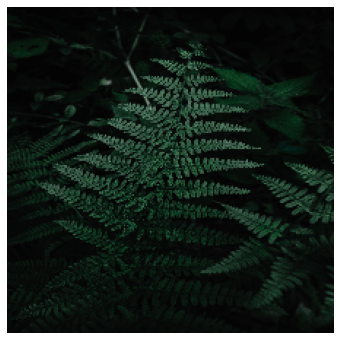

-------------------------------------------


-------------------------------------------
keyword_nature - 100.0%


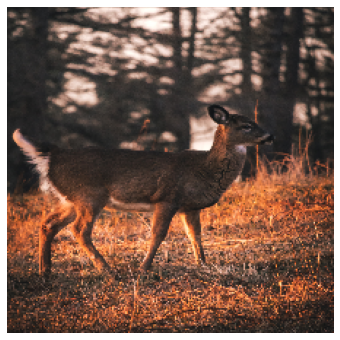

-------------------------------------------


-------------------------------------------
keyword_plant - 100.0%


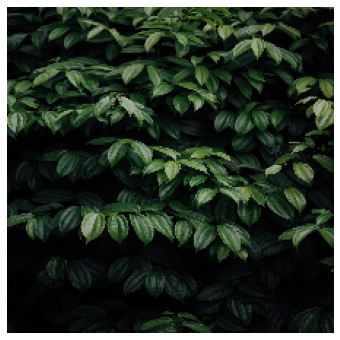

-------------------------------------------


-------------------------------------------
keyword_plant - 100.0%


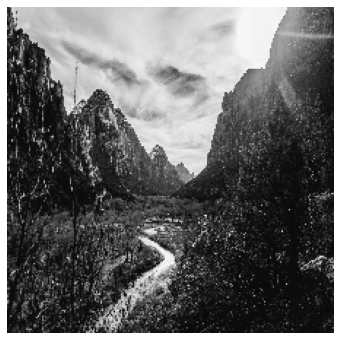

-------------------------------------------


-------------------------------------------
keyword_nature - 99.91999864578247%


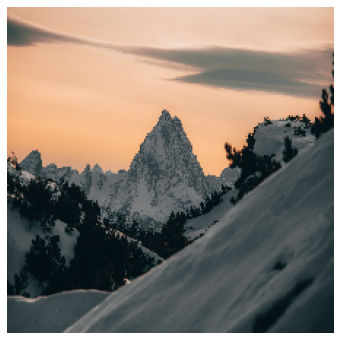

-------------------------------------------


-------------------------------------------
keyword_plant - 100.0%


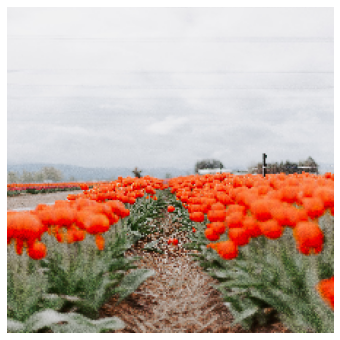

-------------------------------------------


-------------------------------------------
keyword_nature - 100.0%


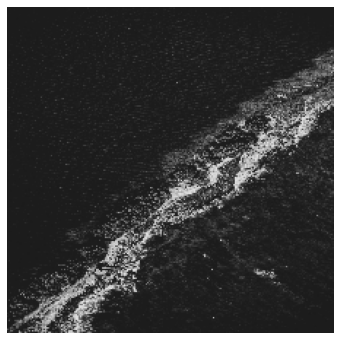

-------------------------------------------




In [23]:
for row in range(10,20):
    pic(X_test[row], y_pred[row], col_dict)

In [25]:
# save model and architecture to single file
model.save("xceptio_model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
inception_model.summary()

In [ ]:

for layer in inception_model.layers[-15:]:
    layer.trainable = True

In [ ]:
opt = Adam(learning_rate=1e-5)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    epochs = 15,
                    batch_size = 64,
                    validation_split = 0.1,
                    callbacks=[model_checkpoint_callback, earlystop])